# ECE 176: Introduction to Deep Learning & Applications
> Final Project Option 2: Context Encoders: Feature Learning by Inpainting<br>
> Author: ChaoYuan Lin<br>
> Research Paper: https://arxiv.org/pdf/1604.07379.pdf<br>
> Dataset: https://www.kaggle.com/datasets/arnaud58/landscape-pictures<br>

### Import packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.models import alexnet
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, ImageDraw
import numpy as np
import os
import matplotlib.pyplot as plt
import random

### Building a Dataloader(code is from Assignment 6)

In [2]:
class CMP_Facade_DB(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data_list)
    
    
    def __getitem__(self, i):
        in_name = self.data_list[i]
        
        in_image = Image.open(in_name).convert('RGB')
        in_image_tensor = self.transform(in_image)
        
        mask = self.create_mask(in_image_tensor)
        
        whiteout_image_tensor = in_image_tensor * (1 - mask)
        
        return whiteout_image_tensor, in_image_tensor, mask

    
    def generate_mask(self, in_image):
        gray_image = in_image.convert('L')
        gray_np = np.array(gray_image)
        
        mask_np = gray_np > 240
        mask = torch.tensor(mask_np, dtype=torch.float32)
        mask = mask.unsqueeze(0)
        return mask

    
    def create_mask(self, image_tensor):
        mask = (image_tensor.mean(dim=0, keepdim=True) > 0.9).float()
        return mask


    def revert_input(self, img_tensor):
        img_tensor = img_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_tensor = img_tensor.clamp(0, 1)
        img_np = img_tensor.permute(1, 2, 0).numpy()
        
        return img_np


### Resize all the image to size 227 X 227

In [3]:
img_names = [img_name for img_name in filter(lambda x: x.lower().endswith('.jpg'), os.listdir("Dataset"))]


def resize_images(input_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

        for img_name in img_names:
            img_path = os.path.join(input_dir, img_name)
            with Image.open(img_path) as img:
                img_resized = img.resize((size, size), Image.LANCZOS)
                output_path = os.path.join(output_dir, img_name)
                img_resized.save(output_path)

input_dir = "Dataset"
output_dir = "Dataset_resize"

resize_images(input_dir, output_dir, 227)


### Image Visualization

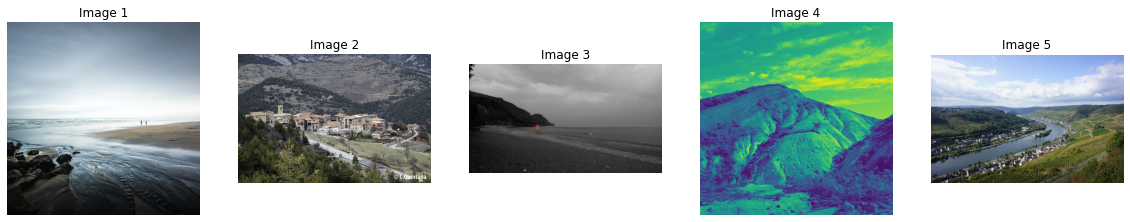

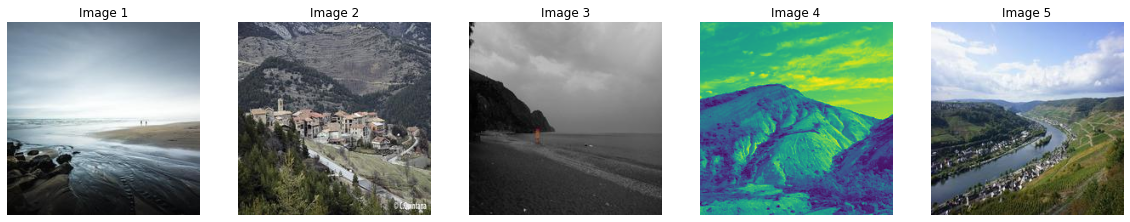

In [4]:
def visualize_5_images(directory):
    
    img_filenames = sorted(img_names)[:5]
    
    plt.figure(figsize=(20, 10))

    for i, img_filename in enumerate(img_filenames):
        
        img = Image.open(os.path.join(directory, img_filename))
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i+1}')

    plt.show()

visualize_5_images(input_dir)
visualize_5_images(output_dir)

### Process images into a list of the data that represent the images for model training(code is from Assignment 6)

In [5]:
def get_full_list(root_dir):
    data_list = []
    data_dir = os.path.join(root_dir)
    data_list += sorted(
        os.path.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

TRAIN_SIZE = 1000
full_data_list = get_full_list(output_dir)

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])

print("Training Set Size:", len(train_data_set))

train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Training Set Size: 1000
using device: cuda


## Context Encoder for image generation
1. Encoder: Given an input image of size 227×227, use the first five convolutional layers and the following pooling layer to compute an abstract 13 × 13 × 256 dimensional feature representation.

2. Channel-wise fully-connected layer: a channel-wise fully-connected layer is used to connect the encoder features to the decoder.

3. Decoder: It generates pixels of the image using the encoder features from a channel-wise fully-connected layer between Encoder and Decoder.

4. Loss Function: Joint Loss Function = Reconstruction Loss + Adversarial Loss
![model.png](model.png)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Linear(4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

# Context encoder using AlexNet until pool5
class ContextEncoder(nn.Module):
    def __init__(self):
        super(ContextEncoder, self).__init__()
        original_alexnet = alexnet(pretrained=True)
        self.encoder = nn.Sequential(*list(original_alexnet.features.children())[:12])
        self.channelwise_fc = ChannelWiseFC(256, 13*13, 13*13)

    def forward(self, x):
        x = self.encoder(x)
        x = self.channelwise_fc(x)
        return x


# Channel Wise Fully Connected layer
class ChannelWiseFC(nn.Module):
    def __init__(self, num_channels, input_size, output_size):
        super(ChannelWiseFC, self).__init__()
        self.num_channels = num_channels
        self.fcs = nn.ModuleList([nn.Linear(input_size, output_size) for _ in range(num_channels)])
        self.dropout = nn.Dropout2d(0.5)
    
    def forward(self, x):
        N, C, H, W = x.size()
        x_flat = x.view(N, C, -1)
        outputs = [self.fcs[i](x_flat[:, i, :]) for i in range(C)]
        output = torch.stack(outputs, dim=1).view(N, C, H, W)
        output = self.dropout(output)
        return output

    
# Decoder layer
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.decoder(x)
        x = F.interpolate(x, size=(227, 227), mode='bilinear', align_corners=False)
        return x

    
# Model for image inpainting
class ImageInpaintingModel(nn.Module):
    def __init__(self):
        super(ImageInpaintingModel, self).__init__()
        self.context_encoder = ContextEncoder()
        self.decoder = Decoder()
        self.loss_fn = nn.MSELoss()

    def forward(self, x, target, mask, discriminator=None):
        encoded_features = self.context_encoder(x * (1 - mask))
        decoded_image = self.decoder(encoded_features)
        inpainted_image = decoded_image * mask + x * (1 - mask)
        
        loss = self.loss_fn(inpainted_image * mask, target * mask)
        adversarial_loss = 0
        
        if discriminator:
            fake_preds = discriminator(inpainted_image)
            real_labels = torch.ones(fake_preds.size(), device=x.device)
            adversarial_loss = F.binary_cross_entropy(fake_preds, real_labels)
        
        return inpainted_image, loss, adversarial_loss

    
# Train Function    
def train_model(generator, discriminator, g_optimizer, d_optimizer, data_loader, num_epochs, device):
    generator.to(device)
    discriminator.to(device)
    adversarial_loss = torch.nn.BCELoss()

    for epoch in range(num_epochs):
        for batch_idx, (data, target, mask) in enumerate(data_loader):
            real_labels = torch.ones(data.size(0), 1, device=device)
            fake_labels = torch.zeros(data.size(0), 1, device=device)

            data, target, mask = data.to(device), target.to(device), mask.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_preds = discriminator(target)
            real_loss = adversarial_loss(real_preds, real_labels)

            with torch.no_grad():
                inpainted_image, _, _ = generator(data, target, mask)
            fake_preds = discriminator(inpainted_image)
            fake_loss = adversarial_loss(fake_preds, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            _, g_loss, g_adv_loss = generator(data, target, mask, discriminator)
            g_total_loss = g_loss + g_adv_loss
            g_total_loss.backward()
            g_optimizer.step()

            if (batch_idx + 1) % 1000 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(data_loader)}], '
                      f'Discriminator Loss: {d_loss.item():.4f}, '
                      f'Generator Loss: {g_loss.item():.4f}, '
                      f'Adversarial Loss: {g_adv_loss.item():.4f}')


model = ImageInpaintingModel()
discriminator = Discriminator()
g_optimizer = optim.Adam(model.parameters(), lr=1e-5)
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, discriminator, g_optimizer, d_optimizer, train_loader, num_epochs=30, device=device)

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Step [1000/1000], Discriminator Loss: 0.5612, Generator Loss: 0.8222, Adversarial Loss: 1.0712
Epoch [2/30], Step [1000/1000], Discriminator Loss: 1.2217, Generator Loss: 0.6964, Adversarial Loss: 0.5264
Epoch [3/30], Step [1000/1000], Discriminator Loss: 0.1062, Generator Loss: 1.1305, Adversarial Loss: 2.6079
Epoch [4/30], Step [1000/1000], Discriminator Loss: 2.2261, Generator Loss: 0.0023, Adversarial Loss: 0.1596
Epoch [5/30], Step [1000/1000], Discriminator Loss: 0.9448, Generator Loss: 0.1240, Adversarial Loss: 2.2679
Epoch [6/30], Step [1000/1000], Discriminator Loss: 1.2413, Generator Loss: 0.0498, Adversarial Loss: 0.5463
Epoch [7/30], Step [1000/1000], Discriminator Loss: 1.0759, Generator Loss: 0.0434, Adversarial Loss: 0.9242
Epoch [8/30], Step [1000/1000], Discriminator Loss: 0.7757, Generator Loss: 0.4957, Adversarial Loss: 1.2635
Epoch [9/30], Step [1000/1000], Discriminator Loss: 1.4185, Generator Loss: 0.0157, Adversarial Loss: 1.3678
Epoch [10/30], Step

### Compare the result with whiteout images and inpainting images

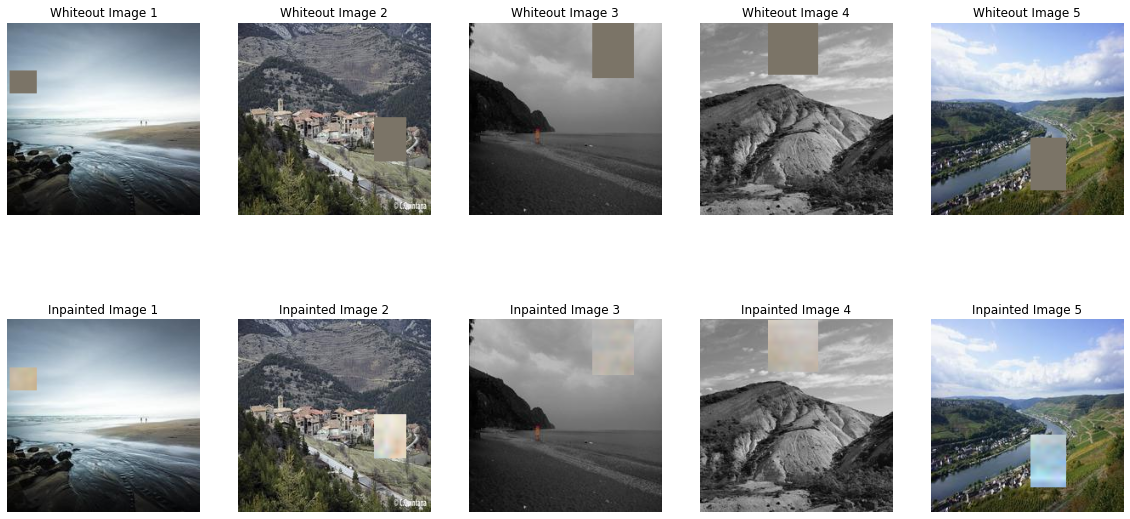

In [44]:
def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)


def unnormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    if image_tensor.is_cuda:
        mean = mean.to(image_tensor.device)
        std = std.to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    image_tensor = image_tensor.clamp(0, 1)
    return image_tensor


def create_white_mask(image_tensor, mask_height_range=(0.1, 0.3), mask_width_range=(0.1, 0.3)):
    
    if image_tensor.dim() == 4:
        _, _, H, W = image_tensor.size()
    else:
        _, H, W = image_tensor.size()


    mask_height = torch.randint(int(H * mask_height_range[0]), int(H * mask_height_range[1]), (1,)).item()
    mask_width = torch.randint(int(W * mask_width_range[0]), int(W * mask_width_range[1]), (1,)).item()

    
    x_top_left = torch.randint(0, W - mask_width, (1,)).item()
    y_top_left = torch.randint(0, H - mask_height, (1,)).item()

    
    mask = torch.zeros((H, W))

    
    mask[y_top_left:y_top_left+mask_height, x_top_left:x_top_left+mask_width] = 1

    
    mask = mask.unsqueeze(0)
    if image_tensor.dim() == 4:
        mask = mask.unsqueeze(0)

    return mask



def visualize_5_images(directory, model, device):
    img_filenames = sorted(os.listdir(directory))[:5]
    
    plt.figure(figsize=(20, 10))

    for i, img_filename in enumerate(img_filenames):
        img_path = os.path.join(directory, img_filename)
        image_tensor = load_and_preprocess_image(img_path)
        mask = create_white_mask(image_tensor)


        image_tensor, mask = image_tensor.to(device), mask.to(device)


        model.eval()
        with torch.no_grad():
            
            inpainted_tensor, _, _ = model(image_tensor, image_tensor, mask)

        
        whiteout_image = unnormalize(image_tensor * (1 - mask)).cpu().squeeze(0).permute(1, 2, 0).numpy()
        inpainted_image = unnormalize(inpainted_tensor).cpu().squeeze(0).permute(1, 2, 0).numpy()


        plt.subplot(2, 5, i+1)
        plt.imshow(whiteout_image)
        plt.axis('off')
        plt.title(f'Whiteout Image {i+1}')

        plt.subplot(2, 5, i+6)
        plt.imshow(inpainted_image)
        plt.axis('off')
        plt.title(f'Inpainted Image {i+1}')

    plt.show()
    
    
visualize_5_images(output_dir, model, device)